# Reshaping Tables

This notebook will cover the many ways of restructuring tables. Restructing tables consists of "rotating" rows into columns, and vice-versa. The operation in Pandas is similar to how an Excel Pivot Table works, but is more general. 

First, we will load a few demonstration datasets, which have two descriptive variables and randomly distributed integers. We will have two versions, one in "Long" format, and one in "Wide" format. Here are the two tables we will be working with, both with the same data, but in different formats


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline; margin:30px'; ").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


In [2]:
df_wide = pd.read_csv('http://ds.civicknowledge.org.s3.amazonaws.com/civicknowledge.com/pandas-training/colors-sizes-wide.csv',
                   parse_dates=['datetime'])
df_wide['datetime'] = df_wide.datetime.dt.date # Just dates, so remove the time component

df_long = pd.read_csv('http://ds.civicknowledge.org.s3.amazonaws.com/civicknowledge.com/pandas-training/colors-sizes-long.csv',
                   parse_dates=['datetime'])
df_long['datetime'] = df_long.datetime.dt.date

display_side_by_side([df_long.head(10), df_wide.head(10)],['Long Format','Wide Format'])


,color,siz,datetime,measure,value
0,blue,large,2013-05-03,frequency,1627
1,blue,large,2013-05-03,opacity,1797
2,blue,large,2013-05-03,focus,592
3,blue,large,2013-05-03,squelch,2241
4,blue,large,2013-05-03,barity,5989
5,blue,large,2013-05-06,frequency,2667
6,blue,large,2013-05-06,opacity,1578
7,blue,large,2013-05-06,focus,509
8,blue,large,2013-05-06,squelch,2241
9,blue,large,2013-05-06,barity,5960


Note that the 'size' colume is spelled 'siz', because there is a ``.size`` property of the dataframe, so ``df.size`` will not return the size column, but rather how much memory the dataframe consumes. Renaming the column alows us to access it with both ``df['siz']`` and ``df.siz`` 

# Pivoting Tables
The Wide format is much more useful for data analysis, because most Pandas functions default to expect each column to have values for one and only one measurement. In the long format, the `measure` column does not have a measurement -- it has the name of the measurement -- and the `values` column has values for multiple measurements. So, we'll want to convert datasets in the long format to the wide format. There are a few ways to do that. 

The most flexible is the ``DataFrame.unstack()`` [(docs)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html) method, which will pivot the contents of a multi-index into columns. A Multi-index is an index created from multiple columns, where each column becomes a "level" in the index. To demonstrate, lets reate a small dataframe from colors and sizes and show how a multi-index works. 

First we'll explore the multi-index, then show how ``.unstack()`` works, using a smaller dataset. 


In [3]:
# Use a smaller dataset for this example. 
cs = pd.read_csv('http://ds.civicknowledge.org.s3.amazonaws.com/civicknowledge.com/pandas-training/colors-sizes-small.csv')
cs.head()

,color,siz,orient,i,j
0,red,small,up,0,0
1,red,small,down,0,0
2,red,medium,up,0,0
3,red,medium,down,0,1
4,red,large,up,0,0


First we will create the multi-index. In the table below, the index is all of the columns in bold, and it is a multi-index because there is more than one column in the index.   Note that with the multi-index, all of the rows that have a value of 'red' are grouped together, within each color, all of the sizes are grouped, and the last level, ``orient`` is sorted the same in every group. 

In [4]:

cs = cs.set_index(['color','siz','orient'])
cs.head(10) 

i  j
color siz    orient      
red   small  up      0  0
             down    0  0
      medium up      0  0
             down    0  1
      large  up      0  0
             down    0  2
blue  small  up      1  0
             down    1  0
      medium up      1  0
             down    1  1

In the ``MultiIndex`` object, the 'levels' values are the unique values for the labels in each of the columns in the index: "color", "orient" and "siz". 

Multi-indexed are a very powerful feature for manipulating data, and we'll explore more about them later. For now we have enough to understand ``.unstack()``, which will operate on the last (rightmost ) level in a multi-index. 

First, create creating a multi-index from the `color`, `size`, `datetime` and `measure` columns, leaving only the `value` column in the body of the dataframe.  

In [5]:
# Back to using the full long dataset
t = df_long.set_index(['color','siz','datetime','measure']) # Set the index
t.head()


value
color siz   datetime   measure         
blue  large 2013-05-03 frequency   1627
                       opacity     1797
                       focus        592
                       squelch     2241
                       barity      5989

Then unstack the last level, measure, into columns. 

In [6]:
t.unstack().head() # unstack the last level, measure

value                                
measure                barity focus frequency opacity squelch
color siz   datetime                                         
blue  large 2013-05-03   5989   592      1627    1797    2241
            2013-05-06   5960   509      2667    1578    2241
            2013-05-08   6070   876      3790    2042    1913
            2013-05-10   5944   584      1007    2065    2181
            2013-05-13   5981   723      1192    1546    2091

The ``unstack()`` method will ( without any arguments ) take the last index level (rightmost, `measure`) of the index columns and rotate into columns. Notice in the 'Before' and 'After' tables below that the values in the ``measure`` column have become the new column names. 

In [7]:

display_side_by_side([df_long.set_index(['color','siz','datetime','measure']).head(10), 
                      df_long.set_index(['color','siz','datetime','measure']).unstack().head(10)],
                     ['Before: After Setting Index','After: After Unstacking'])


Note how rows have rotated into columns: 

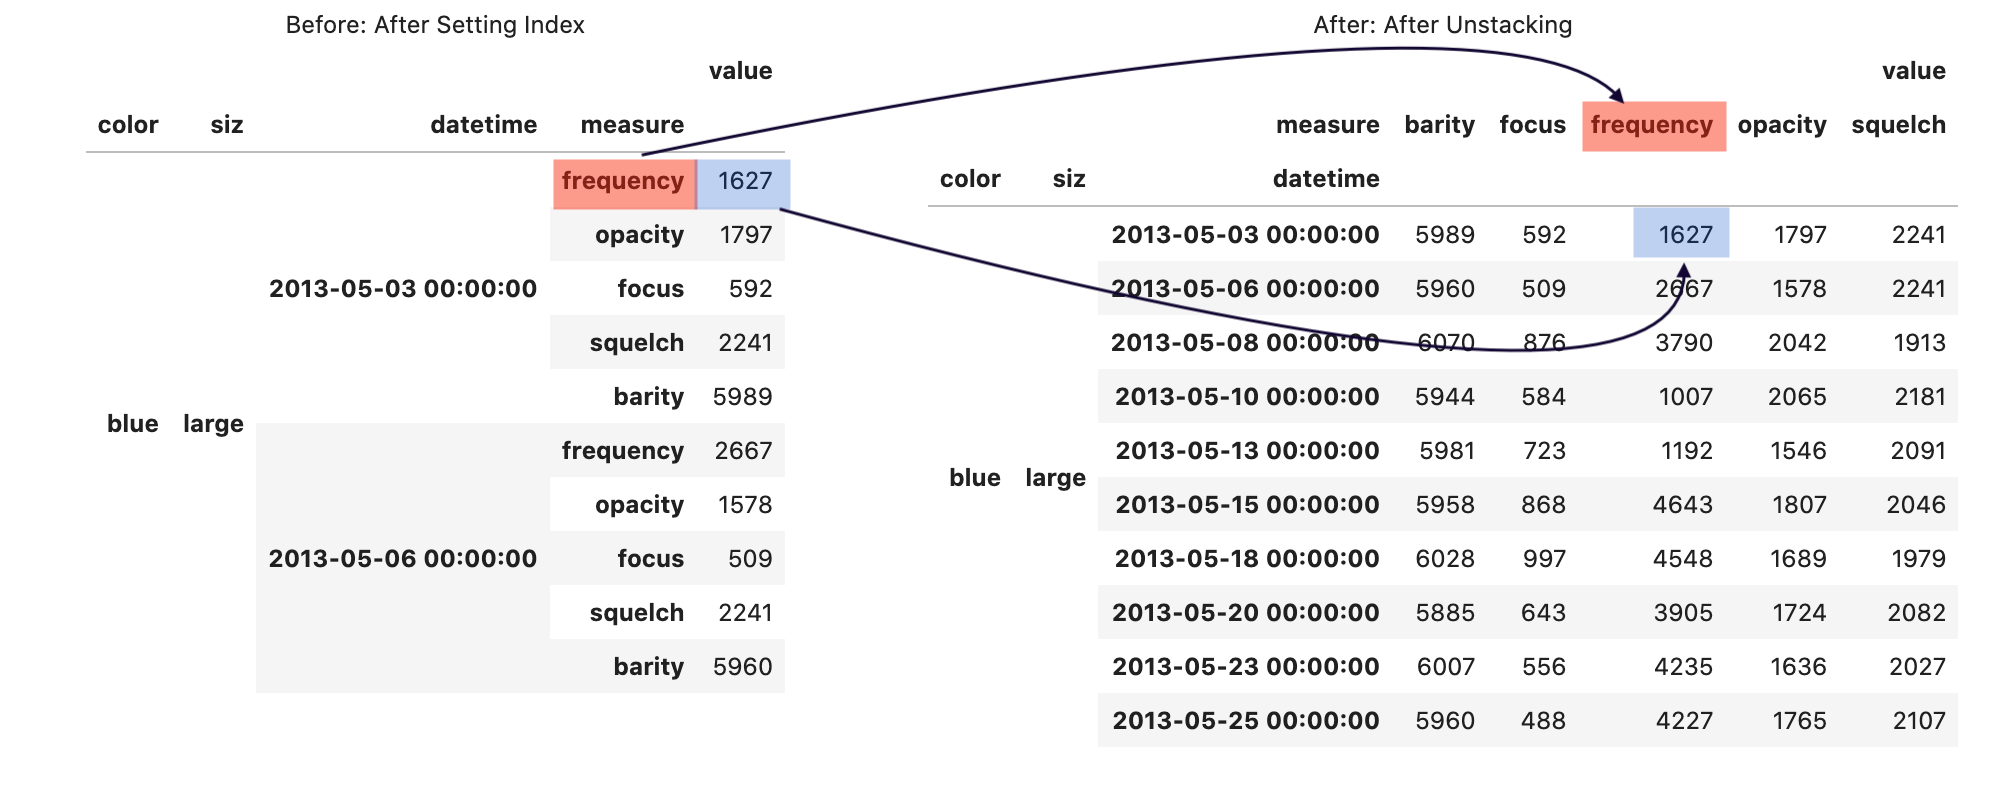

The ``DataFrame.pivot()``[(docs)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html) method operates similarly, but it rotates columns, not the index. The ``.pivot()`` method can only specify one column to use for the index, so all of the other columns get rotated, resulting in a multi-level columns. 

In [8]:
df_long.pivot(index='datetime', columns='measure').sort_index().head()


color                                    siz                   \
measure    barity focus frequency opacity squelch barity  focus frequency   
datetime                                                                    
2010-01-01    red   red       red     red     red  small  small     small   
2010-01-03    red   red       red     red     red  small  small     small   
2010-01-06    red   red       red     red     red  small  small     small   
2010-01-08    red   red       red     red     red  small  small     small   
2010-01-11    red   red       red     red     red  small  small     small   

                            value                                  
measure    opacity squelch barity focus frequency opacity squelch  
datetime                                                           
2010-01-01   small   small   3379   267      3774    1805     764  
2010-01-03   small   small   3492   409      2461    1822     623  
2010-01-06   small   small   3554   424      4579    1852     858  
2010-01-08   small   small   3285   212      3926    1759     738  
2010-01-11   small   small   3464   218      2490    1667     713

There are some important things to notice here: 
* We got a multi-index in columns
* The value/measure columns ( the numbers ) have the sums of the measure for each date

This is probably not what you'd want. Unless you are expecting a mult-index and sums, you probably want to be more selective about what data you are using pivot on. So, let's do it again, but: 

* Select only one gorup of colors and sizes, 'blue' and 'large'
* Remove the color and size columns, because they will be constant. 



In [9]:
t = df_long[(df_long.color == 'blue') & (df_long.siz == 'large')]

t = t[['datetime','measure','value']]

t.pivot(index='datetime', columns='measure').sort_index().head()


value                                
measure    barity focus frequency opacity squelch
datetime                                         
2013-05-03   5989   592      1627    1797    2241
2013-05-06   5960   509      2667    1578    2241
2013-05-08   6070   876      3790    2042    1913
2013-05-10   5944   584      1007    2065    2181
2013-05-13   5981   723      1192    1546    2091

Compare this table to the unstacked version in the previous example

If you want to retain the groupings of the color and size columns, you can use a multi-index. The result will be the same as the ``.unstack()`` example. Since you can't set more than one index value in ``.pivot()``, you have to use ``.set_index()`` 

In [10]:
df_long.set_index(['color','siz','datetime']).pivot(columns='measure').head()

value                                
measure                barity focus frequency opacity squelch
color siz   datetime                                         
blue  large 2013-05-03   5989   592      1627    1797    2241
            2013-05-06   5960   509      2667    1578    2241
            2013-05-08   6070   876      3790    2042    1913
            2013-05-10   5944   584      1007    2065    2181
            2013-05-13   5981   723      1192    1546    2091

The ``pandas.pivot_table()`` [(docs)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot_table.html) function -- note it is a function, not a method of the ``DataFrame`` object -- is similar but more sophsiticated. Note that we don't need to set the index first; the index columns can be specified with the ``index=`` argument using a list. 

In [11]:

pd.pivot_table(df_long, index=['color','siz','datetime'], columns='measure').head()

value                                
measure                barity focus frequency opacity squelch
color siz   datetime                                         
blue  large 2013-05-03   5989   592      1627    1797    2241
            2013-05-06   5960   509      2667    1578    2241
            2013-05-08   6070   876      3790    2042    1913
            2013-05-10   5944   584      1007    2065    2181
            2013-05-13   5981   723      1192    1546    2091

The ``pandas.pivot_table()`` has some other features, such as being able to handle multiple values per cell. If we leave off the ``datetime`` column from the index, then each combination of ``color`` and ``size`` will have 100 values. ``DataFrame.pivot()`` would crash in this case, but ``pandas.pivot_table()`` will just take the mean of the multiple values. 

In [12]:
pd.pivot_table(df_long, index=['color','siz'], columns='measure').head(10)

value                                     
measure          barity    focus frequency  opacity  squelch
color  siz                                                  
blue   large    5967.11   684.87   2938.96  1817.67  2108.81
       medium   8144.11   678.79   2781.16  1784.94  1400.03
       small    6424.85   697.48   2907.81  1761.97   721.75
green  large   13134.12  1025.70   3084.75  1822.01  2087.78
       medium  11537.13  1034.45   3030.16  1795.52  1387.37
       small    7553.27  1065.33   2885.12  1789.72   689.50
orange large   17496.38  1757.37   3047.19  1823.34  2104.96
       medium  23196.42  1738.02   3108.71  1826.56  1411.95
       small   14637.02  1695.31   3060.55  1803.55   721.12
red    large    4808.31   354.00   3125.70  1792.90  2100.71

With ``pandas.pivot_table()``, you can change the aggregation function with the ``aggfunc=`` argument. Let's use the median instead of the mean. 

In [13]:
pd.pivot_table(df_long, index=['color','siz'], columns='measure', aggfunc=np.median).head(10)

value                                  
measure         barity   focus frequency opacity squelch
color  siz                                              
blue   large    5975.0   676.5    3098.5  1802.0  2111.5
       medium   8145.0   659.5    2730.0  1780.0  1404.5
       small    6419.5   684.5    3023.5  1728.5   718.5
green  large   13149.0  1038.0    3178.5  1836.5  2086.5
       medium  11543.5   996.0    3156.5  1798.0  1382.5
       small    7560.0  1091.5    2977.5  1812.5   690.0
orange large   17486.0  1689.5    3025.5  1849.5  2115.0
       medium  23201.5  1672.0    3249.5  1835.5  1400.5
       small   14620.5  1760.0    3026.5  1800.0   722.0
red    large    4819.0   353.5    3131.0  1790.5  2118.5

The final way to pivot is with ``pandas.crosstab()``, [(docs)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html), which works similarly to ``.pivot_table()``, but is oriented around building cross-tabulation frequency tables. For instance, ``pandas.crosstab()`` can normalize rows or columns to 1 and compute sums in the margins. The following produces counts of all lof the combinations of ``size`` and ``color``

In [14]:
pd.crosstab(index=[df_long.color, df_long['siz']], columns=df_long.measure,margins=True)

measure        barity  focus  frequency  opacity  squelch   All
color  siz                                                     
blue   large      100    100        100      100      100   500
       medium     100    100        100      100      100   500
       small      100    100        100      100      100   500
green  large      100    100        100      100      100   500
       medium     100    100        100      100      100   500
       small      100    100        100      100      100   500
orange large      100    100        100      100      100   500
       medium     100    100        100      100      100   500
       small      100    100        100      100      100   500
red    large      100    100        100      100      100   500
       medium     100    100        100      100      100   500
       small      100    100        100      100      100   500
yellow large      100    100        100      100      100   500
       medium     100    100        100      100      100   500
       small      100    100        100      100      100   500
All              1500   1500       1500     1500     1500  7500

# Unpivoting Tables

You can also perform the reverse operation: rotate columns back into columns. There are also a few ways to do this: ``pandas.melt()`` [(doc)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html) and ``DataFrame.stack()`` [(doc)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.stack.html).

Here is how we can use ``.melt()`` to transform the wide dataframe back into the long one. 

In [15]:
melted = pd.melt(df_wide, id_vars=['color','siz','datetime'], var_name='measure')

display_side_by_side([melted.sort_values(['color','siz','datetime']).head(10), df_long.head(10)],
                     ['Wide DataFrame, Melted','Long DataFrame'])


,color,siz,datetime,measure,value
500,blue,large,2013-05-03,frequency,1627
2000,blue,large,2013-05-03,opacity,1797
3500,blue,large,2013-05-03,focus,592
5000,blue,large,2013-05-03,squelch,2241
6500,blue,large,2013-05-03,barity,5989
501,blue,large,2013-05-06,frequency,2667
2001,blue,large,2013-05-06,opacity,1578
3501,blue,large,2013-05-06,focus,509
5001,blue,large,2013-05-06,squelch,2241
6501,blue,large,2013-05-06,barity,5960


The ``DataFrame.stack()`` method is similar, but it operates on the index rather than columns. By default it will stack all of the columns into a new rightmost level in the index. Note that since the ``.stack()`` operation results in a dataframe with only one value, Pandas converts it to a Series, so we use ``.to_frame()`` to convert it back into a DataFrame. Also note that ``.stack()`` doesn't know what to call the level it stack to, so the column names ends up as 'level_3'

In [16]:
df_wide.set_index(['color','siz','datetime']).stack().to_frame('value').reset_index().head(10)

,color,siz,datetime,level_3,value
0,red,small,2010-01-01,frequency,3774
1,red,small,2010-01-01,opacity,1805
2,red,small,2010-01-01,focus,267
3,red,small,2010-01-01,squelch,764
4,red,small,2010-01-01,barity,3379
5,red,small,2010-01-03,frequency,2461
6,red,small,2010-01-03,opacity,1822
7,red,small,2010-01-03,focus,409
8,red,small,2010-01-03,squelch,623
9,red,small,2010-01-03,barity,3492


# Test

For these tests, we will use the simple file from the first example, which you can get from: 

http://ds.civicknowledge.org.s3.amazonaws.com/civicknowledge.com/pandas-training/colors-sizes-small.csv


## Task 1

* Load the CSV file from the link above into a data frame named ``df``.
* Set the index on the dataframe to 'color','siz' and'orient', in that order

( Be sure to either use the "inplace=True" argument when you set the index, or assign back to ``df`` )


In [17]:
# Solution

import pandas as pd
df = pd.read_csv('http://ds.civicknowledge.org.s3.amazonaws.com/civicknowledge.com/pandas-training/colors-sizes-small.csv')
df.set_index(['color','siz','orient'], inplace=True)
df.head()           


i  j
color siz    orient      
red   small  up      0  0
             down    0  0
      medium up      0  0
             down    0  1
      large  up      0  0

In [18]:
# Testing your solution; do not edit
from IPython.display import HTML
assert 'pd' in locals(), "Didn't find the Pandas module imported as pd"
assert 'df' in locals(), "Didn't find a dataframe named df"
assert ','.join(list(df.index.names)) == 'color,siz,orient', "Dataframe index doesn't look right."


HTML('<p style="color:green; font-size:30pt">Success!</p>')

## Task 2

* Select a dataframe from ``df`` that has only one column, ``i``
* Unstack the ``orient`` column
* Display the head of the resulting dataframe

Remember that if you select a single column with a string indexer, you will get a Series, not a dataframe. To get a dataframe,  can index with a one element list, or use ``Series.to_frame()`` to conver the Series to a list. 


In [19]:
# Solution

df['i'].unstack().head()

orient        down  up
color siz             
blue  large      1   1
      medium     1   1
      small      1   1
green large      2   2
      medium     2   2

In [20]:
# Testing your solution; do not edit

assert 'pd' in locals(), "Didn't find the Pandas module imported as pd"
assert 'df' in locals(), "Didn't find a dataframe named df"
assert _.loc[('blue','large'),:]['up'] == 1,"Output doesn't look right"
assert _.loc[('green','medium'),:]['up'] == 2,"Output doesn't look right"

HTML('<p style="color:green; font-size:30pt">Success!</p>')

# Task 3

* Reset the index on ``df``
* Use the ``DataFrame.pivot_table`` method to display the mean value of the ``i`` column, organized by color and siz
* Display the whole resulting dataframe

In [21]:
# Solution

t = df.reset_index()
t.pivot_table(index='color', columns='siz', values='i')


siz,large,medium,small
color,,,
blue,1,1,1
green,2,2,2
orange,4,4,4
red,0,0,0
yellow,3,3,3


In [22]:
# Testing your solution; do not edit

assert len(_) == 5,'Dataframe should have 5 rows, with an index of colors'
assert len(_.columns) == 3,'Dataframe should have 3 columns, each a size'

HTML('<p style="color:green; font-size:30pt">Success!</p>')